<a href="https://colab.research.google.com/github/lucapap97/TurkishLira/blob/master/Turkish_clean_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install kaggle

In [ ]:
 from google.colab import files
 files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"lucapapparotto","key":"3b7d39a7aa9e459f30d3005d7a51aa5f"}'}

In [ ]:
!ls
!mkdir ~/.kaggle
!chmod 600 kaggle.json
!cp kaggle.json ~/.kaggle/kaggle.json
!kaggle config set -n path -v{/content}

kaggle.json  sample_data
- path is now set to: {/content}


In [ ]:
!kaggle datasets download -d baltacifatih/turkish-lira-banknote-dataset -p /content

100% 3.49G/3.50G [01:08<00:00, 31.4MB/s]
100% 3.50G/3.50G [01:08<00:00, 55.0MB/s]


In [ ]:
!mkdir -p dataset/downloaded
!unzip -q turkish-lira-banknote-dataset.zip -d ./dataset/downloaded
!rm turkish-lira-banknote-dataset.zip
!rm kaggle.json

In [ ]:
!mkdir dataset/txtFiles
!mv dataset/downloaded/train.txt dataset/txtFiles
!mv dataset/downloaded/validation.txt dataset/txtFiles

!mkdir -p dataset/train_set/{\10,100,20,200,5,50}
!mkdir -p dataset/valid_set/{\10,100,20,200,5,50}

In [ ]:
import os


train_file = "dataset/txtFiles/train.txt"

from_path_train = "dataset/downloaded/"
to_path_train = "dataset/train_set/"


with open(train_file, "r") as file1:
    for line in file1:
      os.rename(from_path_train + line[:-1] , to_path_train + line[:-1])

In [ ]:
validation_file = "dataset/txtFiles/validation.txt"

from_path_valid = "dataset/downloaded/"
to_path_valid = "dataset/valid_set/"

with open(validation_file, "r") as file1:
    for line in file1:
      os.rename(from_path_valid + line[:-1] , to_path_valid + line[:-1])

In [ ]:
import tensorflow as tf
from IPython.display import display, clear_output
import numpy as np
import matplotlib.pyplot as plt

AUTO = tf.data.experimental.AUTOTUNE

num_classes = 6
img_width = 80
img_height = img_width * 9//16
BATCH_SIZE = 128
EPOCHS = 10

In [ ]:
#code from lectures
class PlotTraining(tf.keras.callbacks.Callback):
  def __init__(self, sample_rate=1, zoom=1):
    self.sample_rate = sample_rate
    self.step = 0
    self.zoom = zoom
    self.steps_per_epoch = 60000//BATCH_SIZE

  def on_train_begin(self, logs={}):
    self.batch_history = {}
    self.batch_step = []
    self.epoch_history = {}
    self.epoch_step = []
    self.fig, self.axes = plt.subplots(1, 2, figsize=(16, 7))
    plt.ioff()

  def on_batch_end(self, batch, logs={}):
    if (batch % self.sample_rate) == 0:
      self.batch_step.append(self.step)
      for k,v in logs.items():
        # do not log "batch" and "size" metrics that do not change
        # do not log training accuracy "acc"
        if k=='batch' or k=='size':# or k=='acc':
          continue
        self.batch_history.setdefault(k, []).append(v)
    self.step += 1

  def on_epoch_end(self, epoch, logs={}):
    plt.close(self.fig)
    self.axes[0].cla()
    self.axes[1].cla()
      
    self.axes[0].set_ylim(0, 1.2/self.zoom)
    self.axes[1].set_ylim(1-1/self.zoom/2, 1+0.1/self.zoom/2)
    
    self.epoch_step.append(self.step)
    for k,v in logs.items():
      # only log validation metrics
      if not k.startswith('val_'):
        continue
      self.epoch_history.setdefault(k, []).append(v)

    clear_output(wait=True)
    
    for k,v in self.batch_history.items():
      (self.axes[0 if k.endswith('loss') else 1]
           .plot(np.array(self.batch_step) / self.steps_per_epoch, v, label=k))
      
    for k,v in self.epoch_history.items():
      (self.axes[0 if k.endswith('loss') else 1]
           .plot(np.array(self.epoch_step) / self.steps_per_epoch, v,
                 label=k, linewidth=3))
      
    self.axes[0].legend()
    self.axes[1].legend()
    self.axes[0].set_xlabel('epochs')
    self.axes[1].set_xlabel('epochs')
    self.axes[0].minorticks_on()
    self.axes[0].grid(True, which='major', axis='both',
                      linestyle='-', linewidth=1)
    self.axes[0].grid(True, which='minor', axis='both',
                      linestyle=':', linewidth=0.5)
    self.axes[1].minorticks_on()
    self.axes[1].grid(True, which='major', axis='both',
                      linestyle='-', linewidth=1)
    self.axes[1].grid(True, which='minor', axis='both',
                      linestyle=':', linewidth=0.5)
    display(self.fig)

In [ ]:
#code from lectures
def plot_learning_rate(lr_func, epochs):
  xx = np.arange(epochs+1, dtype=np.float)
  y = [lr_decay(x) for x in xx]
  fig, ax = plt.subplots(figsize=(9, 6))
  ax.set_xlabel('epochs')
  ax.set_title('Learning rate\ndecays from {:0.3g} to {:0.3g}'.format(y[0],
                                                                      y[-2]))
  ax.minorticks_on()
  ax.grid(True, which='major', axis='both', linestyle='-', linewidth=1)
  ax.grid(True, which='minor', axis='both', linestyle=':', linewidth=0.5)
  ax.step(xx,y, linewidth=3, where='post')
  display(fig)

In [ ]:
data_augmentation = tf.keras.Sequential(
  [
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

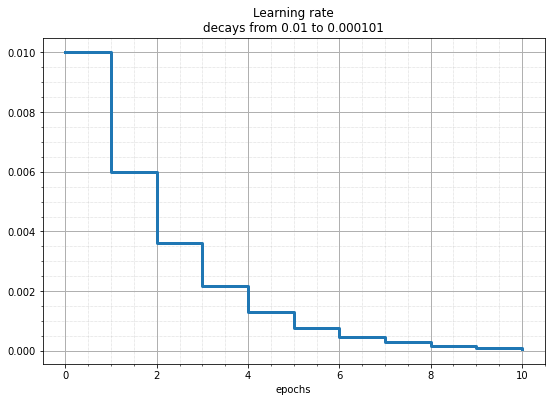

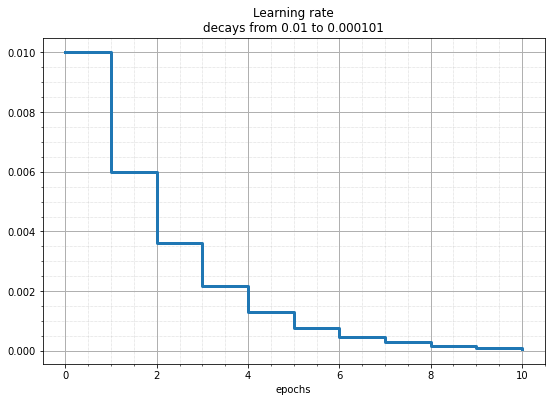

In [ ]:
import math

EPOCHS = 10

def lr_decay(epoch):
  return 0.01 * math.pow(0.6, epoch)

lr_decay_callback = tf.keras.callbacks.LearningRateScheduler(lr_decay, verbose=True)

plot_learning_rate(lr_decay, EPOCHS)

In [ ]:
def get_training_dataset(height,width,batch_size, resize):
    train_ds = tf.keras.preprocessing.image_dataset_from_directory(
        to_path_train,
        labels="inferred",
        label_mode="categorical",
        image_size = (height, width),
        color_mode="rgb",
        batch_size=batch_size,
        shuffle=True,
        seed=None,
        validation_split=None,
        subset=None,
        follow_links=False,
    )
    if(resize):
      train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y), 
                  num_parallel_calls=AUTO)


    train_ds = train_ds.repeat().prefetch(AUTO)
    return train_ds

def get_validation_dataset(height,width):
    validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
        to_path_valid,
        labels="inferred",
        label_mode="categorical",
        image_size = (height, width),
        color_mode="rgb",
        batch_size=450*3,
        shuffle=None,
        seed=None,
        validation_split=None,
        subset=None,
        follow_links=False,
    )
    validation_dataset = validation_dataset.map(lambda x, y: (data_augmentation(x, training=True), y), 
                  num_parallel_calls=AUTO)
    validation_dataset = validation_dataset.repeat()
    return validation_dataset

train_dataset = get_training_dataset(img_height, img_width, BATCH_SIZE, resize = False)

steps_per_epoch = steps_per_epoch = 925*6*3//BATCH_SIZE

validation_dataset = get_validation_dataset(img_height, img_width)



Found 5550 files belonging to 6 classes.
Found 450 files belonging to 6 classes.


In [ ]:
model1 = tf.keras.Sequential([  
  data_augmentation,
  tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),

  tf.keras.layers.Conv2D(kernel_size=3, filters=16, padding='same', use_bias=False),
  tf.keras.layers.BatchNormalization(center=True, scale=False),
  tf.keras.layers.Activation('relu'),
  tf.keras.layers.MaxPooling2D(),


  tf.keras.layers.Conv2D(kernel_size=6, filters=24, padding='same', use_bias=False),
  tf.keras.layers.BatchNormalization(center=True, scale=False),
  tf.keras.layers.Activation('relu'),
  tf.keras.layers.MaxPooling2D(),

  tf.keras.layers.Flatten(),      
  tf.keras.layers.Dense(200, use_bias=False),
  tf.keras.layers.BatchNormalization(center=True, scale=False),
  tf.keras.layers.Activation('relu'),

  tf.keras.layers.Dense(60, use_bias=False),
  tf.keras.layers.BatchNormalization(center=True, scale=False),
  tf.keras.layers.Activation('relu'),
  
  tf.keras.layers.Dropout(0.3),
  tf.keras.layers.Dense(6, activation='softmax')
])

model1.compile(optimizer=tf.keras.optimizers.Adam(lr=0.01),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model1.summary()

plot_training = PlotTraining(sample_rate=10, zoom=6)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 45, 80, 3)         0         
_________________________________________________________________
rescaling (Rescaling)        (None, 45, 80, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 45, 80, 16)        432       
_________________________________________________________________
batch_normalization (BatchNo (None, 45, 80, 16)        48        
_________________________________________________________________
activation (Activation)      (None, 45, 80, 16)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 22, 40, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 22, 40, 24)       

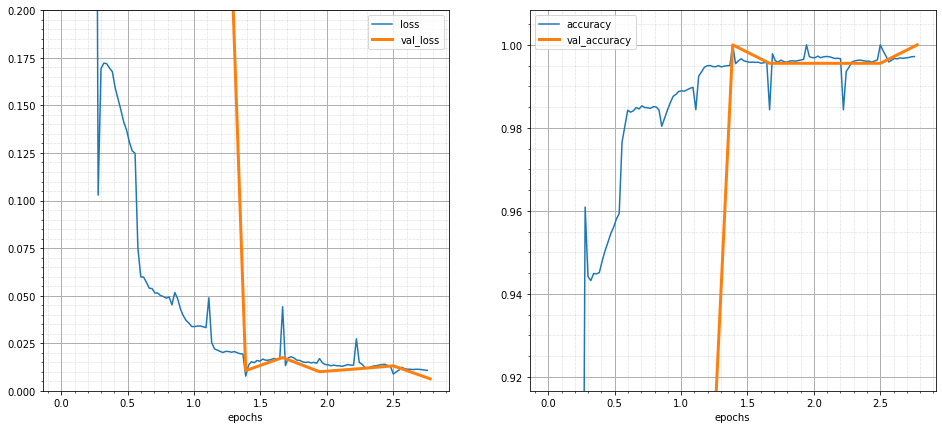

130/130 [==============================] - 310s 2s/step - loss: 0.0111 - accuracy: 0.9970 - val_loss: 0.0063 - val_accuracy: 1.0000


In [ ]:
history = model1.fit(train_dataset,
                    steps_per_epoch=steps_per_epoch,
                    epochs=EPOCHS,
                    validation_data=validation_dataset,
                    validation_steps=1,
                    callbacks=[plot_training, lr_decay_callback])

In [ ]:
uploaded = files.upload()

Saving 10_1_png (A scelta).png to 10_1_png (A scelta) (2).png


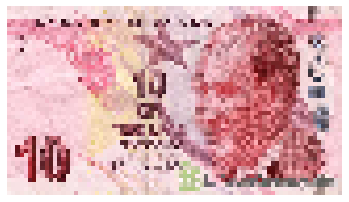

[[9.9966133e-01 2.1507238e-07 3.1824780e-04 8.1467419e-07 1.9366622e-05
  6.0890521e-08]]


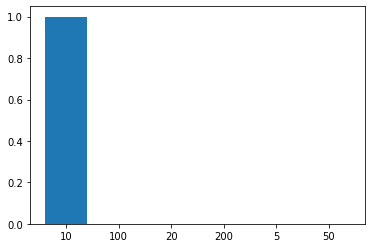

In [ ]:
#uploaded = {"dataset/valid_set/5/5_1_0140.png": "test"}

image = tf.keras.preprocessing.image.load_img(list(uploaded.keys())[0], color_mode="rgb", target_size=(img_height, img_width))
input_arr = tf.keras.preprocessing.image.img_to_array(image)
input_arr = np.array([input_arr])
predictions = model1.predict(input_arr)

plt.imshow(image)
plt.axis("off")
plt.show()

print(predictions)

plt.bar(range(6), predictions[0])
plt.xticks(range(6), class_names)

plt.show()